In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.modules import StudentTOutput

from ConvTSMixer import ConvTSMixerEstimator

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [21]:
estimator = ConvTSMixerEstimator(
    #distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    scaling="std",
    
    depth=4,
        
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cpu")
)

In [ ]:
predictor = estimator.train(
    training_data=dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024, 
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | ConvTSMixerModel | 18.8 K
-------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 4.84968 (best 4.84968), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_37/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 4.42889 (best 4.42889), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_37/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 4.32133 (best 4.32133), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_37/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 4.27519 (best 4.27519), saving model to '/Users/kashif/Github/ConvTS-Mixer/lightning_logs/version_37/checkpoints/epoch=3-step=400.ckpt' as top 1


In [15]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

In [16]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [17]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 178.08it/s]

Running evaluation: 7it [00:00, 245.26it/s]

Running evaluation: 7it [00:00, 265.77it/s]

Running evaluation: 7it [00:00, 266.06it/s]

Running evaluation: 7it [00:00, 256.96it/s]

Running evaluation: 7it [00:00, 264.85it/s]

Running evaluation: 7it [00:00, 272.21it/s]

Running evaluation: 7it [00:00, 276.91it/s]

Running evaluation: 7it [00:00, 277.13it/s]

Running evaluation: 7it [00:00, 272.21it/s]

Running evaluation: 7it [00:00, 269.64it/s]

Running evaluation: 7it [00:00, 278.64it/s]

Running evaluation: 7it [00:00, 257.11it/s]

Running evaluation: 7it [00:00, 267.62it/s]

Running evaluation: 7it [00:00, 273.89it/s]

Running evaluation: 7it [00:00, 275.74it/s]

Running evaluation: 7it [00:00, 267.34it/s]

Running evaluation: 7it [00:00, 277.79it/s]

Running evaluation: 7it [00:00, 266.39it/s]

Running evaluation: 7it [00:00, 272.75it/s]

Running evaluation: 7it [00:00, 272.92it/s]

Running evaluation: 7it [00:00, 274.17it/s]

Running e

In [18]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.5274298866337849
ND: 0.7139994865165923
NRMSE: 1.2519452335883576
MSE: 1486.785953886359


In [19]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

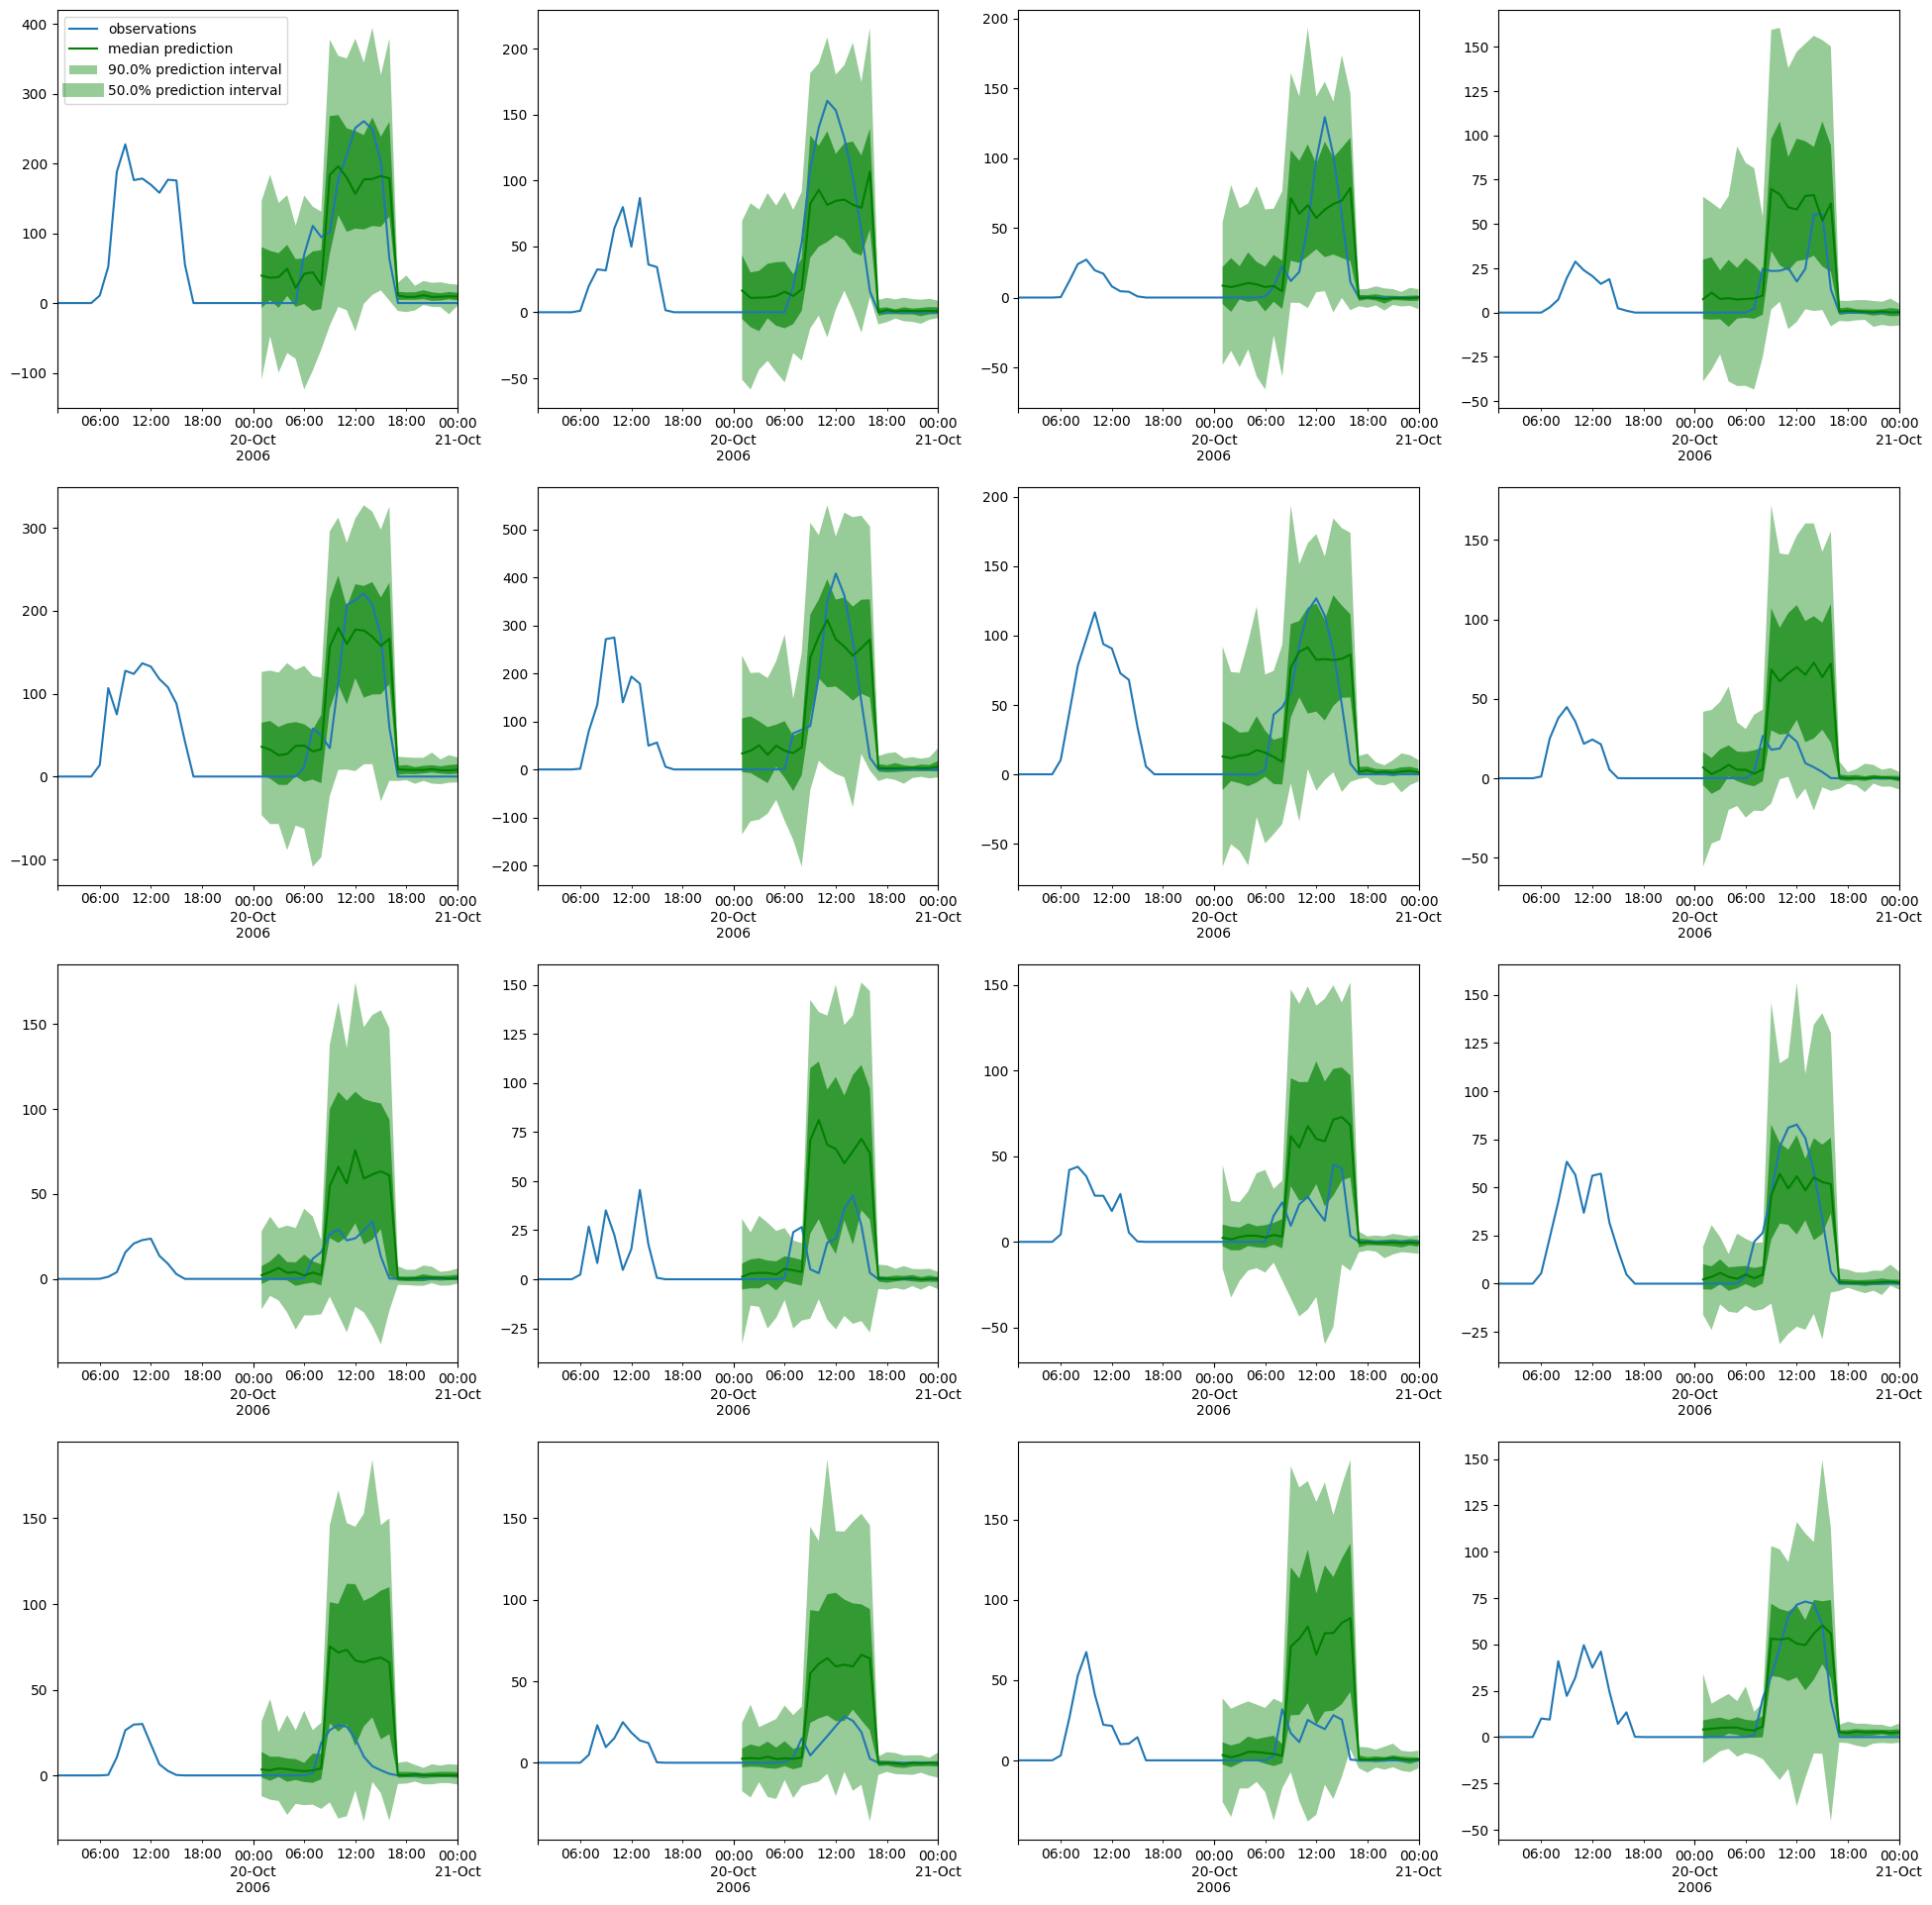

In [20]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()